<a href="https://colab.research.google.com/github/emilyswitzer/celeb-heights/blob/main/Celebs_CNN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

In [ ]:
!unzip "/content/train.zip" -d "/"

In [ ]:
!unzip "/content/205.zip" -d "/content/205"

In [ ]:
import pathlib
import glob
import cv2
#data_dir = "train/"
data_dir = "/content/205"
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3153


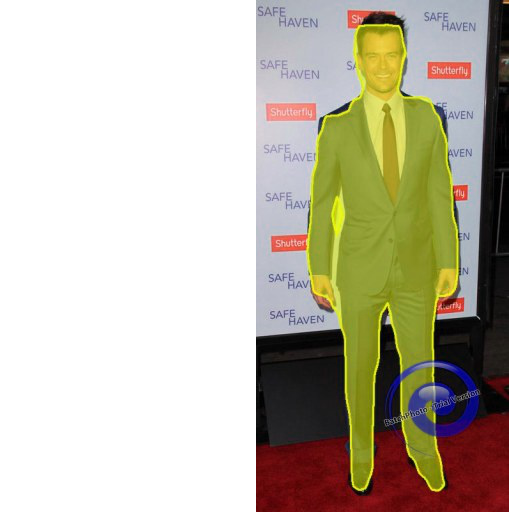

In [ ]:
person = list(data_dir.glob('191/*'))
PIL.Image.open(str(person[10]))


# Load data using a Keras utility


## Create a dataset

In [ ]:
from keras.callbacks import ModelCheckpoint

In [ ]:
batch_size = 8
#img_height = 256
#img_width = 211

img_height = 512
img_width = 509

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  #color_mode="grayscale",
  batch_size=batch_size)


Found 3153 files belonging to 67 classes.
Using 2365 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
 # color_mode="grayscale",
  batch_size=batch_size)

Found 3153 files belonging to 67 classes.
Using 788 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['106', '109', '111', '114', '116', '119', '121', '125', '127', '129', '130', '132', '139', '146', '147', '148', '149', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '177', '178', '179', '180', '181', '182', '183', '184', '185', '188', '190', '191', '192', '193', '194', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210']


## Visualize the data



In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 512, 509, 3)
(8,)


## Standardize the data

The RGB channel values are in the `[0, 255]` range. To keep input values small  standardize values to be in the `[0, 1]` range.

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


# Create the model



## Overfitting

## Data augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

#Create the model with Overfitting Solutions

In [ ]:
num_classes = len(class_names)


model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
 
  
])

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

with strategy.scope():
    inputs = layers.Input(shape=(img_height, image_width, 3))
    x = data_augmentation
    outputs = EfficientNetB0(include_top=True, weights=None, classes=num_classes)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)

In [ ]:
num_classes = len(class_names)


model = Sequential([
  #data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3,padding='same', activation='relu'),
  layers.Conv2D(32, 3,padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3,padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3,padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(num_classes),
])

In [ ]:
checkpoint = ModelCheckpoint('model.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 

x = list/ array of images
y - list/array of number (height)

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
             metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512, 509, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 512, 509, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 509, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 254, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 254, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 127, 32)     0         
 2D)                                                  

In [ ]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
 
 # callbacks=[checkpoint],
  epochs=epochs
)

## Visualize training results


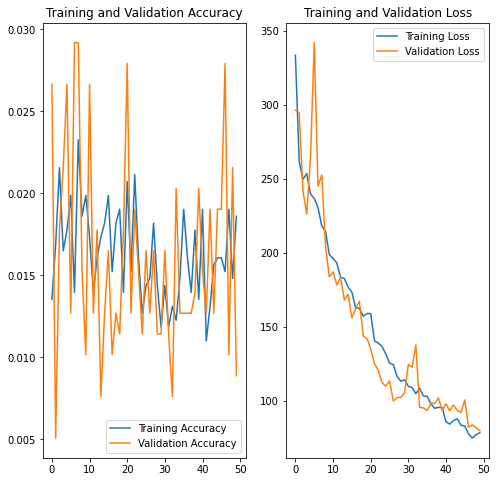

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on unseen data

In [ ]:
!unzip "/content/unseen2.zip" -d "/content/unseen"

Archive:  /content/unseen2.zip
   creating: /content/unseen/content/unseen2/
  inflating: /content/unseen/content/unseen2/139.jpg  
  inflating: /content/unseen/content/unseen2/198.jpg  
  inflating: /content/unseen/content/unseen2/192.jpg  
  inflating: /content/unseen/content/unseen2/157.jpg  
  inflating: /content/unseen/content/unseen2/194.jpg  
  inflating: /content/unseen/content/unseen2/179.jpg  
  inflating: /content/unseen/content/unseen2/155.jpg  
  inflating: /content/unseen/content/unseen2/206.jpg  
  inflating: /content/unseen/content/unseen2/153.jpg  
  inflating: /content/unseen/content/unseen2/148.jpg  
  inflating: /content/unseen/content/unseen2/166.jpg  
  inflating: /content/unseen/content/unseen2/106.jpg  
  inflating: /content/unseen/content/unseen2/201.jpg  
  inflating: /content/unseen/content/unseen2/189.jpg  
  inflating: /content/unseen/content/unseen2/109.jpg  
  inflating: /content/unseen/content/unseen2/161.jpg  
  inflating: /content/unseen/content/unseen

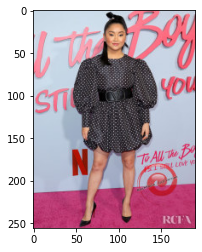

The person is 7.38 percent 146 cm 


In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread('/content/155.jpg')
imgplot = plt.imshow(img)
plt.show()
sunflower_path = '/content/155.jpg'

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])




print(
    "The person is {:.2f} percent {} cm "
    .format(100 * np.max(score),class_names[np.argmax(score)])
)

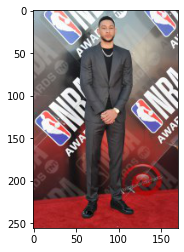

The person is 4.04 percent 207 cm 


In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread('/content/204.jpg')
imgplot = plt.imshow(img)
plt.show()
sunflower_path = '/content/204.jpg'

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])




print(
    "The person is {:.2f} percent {} cm "
    .format(100 * np.max(score),class_names[np.argmax(score)])
)